# fMRI Demo (premade patterns version)

## About this demo

In this demo we'll load a set of multi-voxel patterns that have been pre-calculated with [this script](https://github.com/rsagroup/rsatoolbox/blob/main/demos/prepare_demo_fmri_patterns.py). See the [nilearn demo](https://rsatoolbox.readthedocs.io/en/stable/demo_fmri_nilearn.html) for a step by step look at how to calculate such patterns from this dataset. This demo takes the analysis a bit further and shows how to make inferences using the rsatoolbox.


## The Dataset

The data used for this demo was kindly provided by Marieke Mur. This study is still under review, so we will update this demo to include steps to download the data when it becomes publicly available. 

Participants (n=14) viewed images of 16 objects, as well as their written name. Several properties of the stimuli were carefully balanced. They also performed several tasks, but for the purposes of this demo we will ignore these.

![stimuli](demo_fmri_files/mur32_stims.png)

Run the following imports:

In [1]:
%matplotlib inline
from os.path import expanduser, join
import json
import numpy, pandas
import matplotlib.pyplot as plt
from rsatoolbox.data.dataset import Dataset
from rsatoolbox.data.noise import prec_from_residuals
from rsatoolbox.rdm.calc import calc_rdm
from rsatoolbox.rdm.rdms import concat
from rsatoolbox.vis.rdm_plot import show_rdm
from rsatoolbox.model.model import ModelFixed
from rsatoolbox.inference.evaluate import eval_dual_bootstrap
from rsatoolbox.vis.model_plot import plot_model_comparison

Let's define the path to where we stored the patterns:

In [2]:
data_dir = expanduser('~/data/rsatoolbox/mur32/derivatives/nilearn')

Here we load the data from a numpy archive, and some metadata variables from a json file:

In [3]:
print('Loading..')
with open(join(data_dir, 'meta.json')) as fhandle:
    metadata = json.load(fhandle)
data = numpy.load(join(data_dir, 'data.npz'))

Loading..


Let's have a look to see which cortical structures we have data for:

In [4]:
metadata['region_names']

['cuneus',
 'pericalcarine',
 'lingual',
 'fusiform',
 'lateraloccipital',
 'inferiortemporal',
 'inferiorparietal']

From these let's select the *Fusiform* and *Inferior Temporal* (IT) gyri.

In [5]:
regions_of_interest = ['fusiform', 'lateraloccipital', 'inferiortemporal']

We obtain a few other details about the dataset:

In [6]:
subjects = metadata['subjects']
conditions = metadata['conditions']
degrees_of_freedom = metadata['degrees_of_freedom']
N_RUNS = 6
subjects = ['07', '08', '09', '10', '11', '12', '13']

No we can go ahead and for each brain region and participant, we load the beta patterns, GLM residuals, and calculate an RDM. This may take a few minutes:

In [19]:
rdm_list = []
for region_name in regions_of_interest:
    for sub in subjects:
        print(f'roi {region_name} sub {sub}')

        # load the beta patterns for this subject and collapse the run dimension
        betas = data[f'betas_sub-{sub}_{region_name}']
        patterns = betas.reshape(-1, betas.shape[-1])

        # create an rsatoolbox Dataset with the patterns
        ds = Dataset(
            measurements=patterns,
            descriptors=dict(sub=sub, roi=region_name),
            obs_descriptors=dict(
                run=numpy.repeat(numpy.arange(N_RUNS), len(conditions)),
                condition=numpy.tile(conditions, N_RUNS)
            )
        )

        # for every run, calculate the precision matrix from the residuals
        runwise_prec_matrix = []
        resids = data[f'resids_sub-{sub}_{region_name}']
        for r in range(N_RUNS):
            runwise_prec_matrix.append(
                prec_from_residuals(
                    resids[r, :, :],
                    dof=degrees_of_freedom,
                    method='shrinkage_diag'
                )
            )

        # calculate crossnobis RDMs from the patterns and precision matrices
        rdm_list.append(
            calc_rdm(
                dataset=ds,
                noise=runwise_prec_matrix,
                method='crossnobis',
                descriptor='condition',
                cv_descriptor='run',
            )
        )
        
        del rdm_list[-1].descriptors['noise'] # saves memory

roi fusiform sub 07


/Users/jasper/projects/rsatoolbox/env/lib/python3.11/site-packages/rsatoolbox/data/computations.py:36: RuntimeWarning: invalid value encountered in multiply
  average = np.nan * np.empty(
/Users/jasper/projects/rsatoolbox/env/lib/python3.11/site-packages/numpy/core/numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


roi fusiform sub 08
roi fusiform sub 09
roi fusiform sub 10
roi fusiform sub 11
roi fusiform sub 12
roi fusiform sub 13
roi lateraloccipital sub 07
roi lateraloccipital sub 08
roi lateraloccipital sub 09
roi lateraloccipital sub 10
roi lateraloccipital sub 11
roi lateraloccipital sub 12
roi lateraloccipital sub 13
roi inferiortemporal sub 07
roi inferiortemporal sub 08
roi inferiortemporal sub 09
roi inferiortemporal sub 10
roi inferiortemporal sub 11
roi inferiortemporal sub 12
roi inferiortemporal sub 13


Next we can use the `concat` function to merge all RDMs into a single object, which means we have some options for selection later:

In [8]:
data_rdms = concat(rdm_list)

Let's have a look at the RDM's for the Fusiform Gyrus:

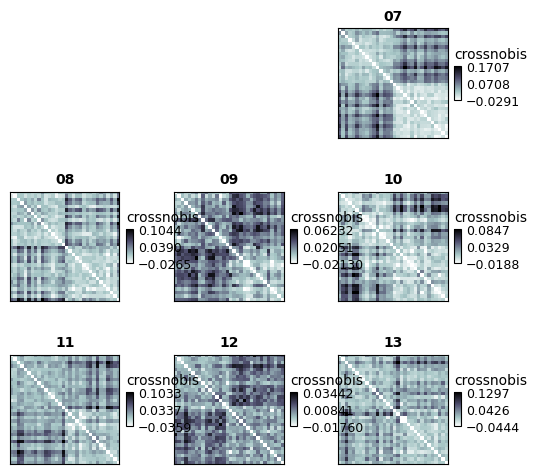

In [9]:
fusiform_rdms = data_rdms.subset('roi', 'fusiform')
fig, _, _ = show_rdm(
    fusiform_rdms,
    rdm_descriptor='sub',
    show_colorbar='panel'
)
plt.show()

We can use a similar statement to select all RDM's for a given participant:

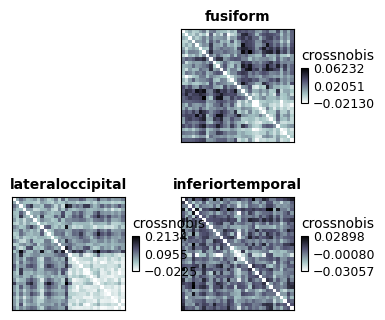

In [10]:
sub12_rdms = data_rdms.subset('sub', '09')
fig, _, _ = show_rdm(
    sub12_rdms,
    rdm_descriptor='roi',
    show_colorbar='panel'
)
plt.show()

Let's create a selection for the *Inferior Temporal gyrus* as well:

In [11]:
it_rdms = data_rdms.subset('roi', 'inferiortemporal')
it_rdms = data_rdms.subset('roi', 'lingual')

## Model

Let's map the various stimulus properties of interest on a table (and display 5 random rows):

In [12]:
INDOOR = ['bagel', 'candle', 'clock', 'glass', 'kettle', 'knife', 'sponge', 'table']
STRAIGHT = ['candle', 'knife', 'sponge', 'table', 'spade', 'ladder', 'brick', 'pedal']
MONOSYL = ['knife', 'clock', 'spade', 'wheel', 'glass', 'sponge', 'glove', 'brick']
TOOL = ['knife', 'sponge', 'spade', 'pedal', 'kettle', 'ladder', 'glass']
df = pandas.DataFrame([dict(
    trial_type=c,
    indoor=float(c.split('_')[1] in INDOOR),
    straight=float(c.split('_')[1] in STRAIGHT),
    syllables=float(c.split('_')[1] in MONOSYL),
    tool=float(c.split('_')[1] in TOOL),
    modality=float('image_' in c),
) for c in conditions])
df.sample(5)

,trial_type,indoor,straight,syllables,tool,modality
25,text_ladder,0.0,1.0,0.0,1.0,0.0
2,image_candle,1.0,1.0,0.0,0.0,1.0
19,text_clock,1.0,0.0,1.0,0.0,0.0
20,text_glass,1.0,0.0,1.0,1.0,0.0
16,text_bagel,1.0,0.0,0.0,0.0,0.0


We can then turn these into Model RDMs

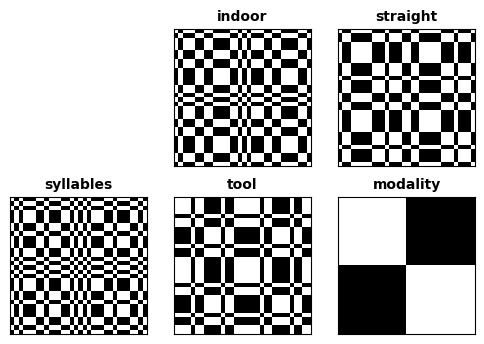

In [13]:
model_dataset = Dataset.from_df(df)
model_rdms = calc_rdm(
    [model_dataset.split_channel('name')],
    method='euclidean',
    descriptor='trial_type'
)
model_rdms.rdm_descriptors['name'] = model_dataset.channel_descriptors['name']
fig, _, _ = show_rdm(model_rdms, rdm_descriptor='name')
plt.show()

Next, we wrap each of the model RDMs in their own fixed `Model` object.

In [14]:
models = []
for model_name in model_rdms.rdm_descriptors['name']:
    model_rdm = model_rdms.subset('name', model_name)
    models.append(ModelFixed(model_name, model_rdm))

## Inference

Let's see how well each of these models explains the fMRI data RDMs for the Fusiform:

In [15]:
result_fusiform = eval_dual_bootstrap(models, fusiform_rdms)
print(result_fusiform)

100%|██████████| 1000/1000 [00:05<00:00, 193.69it/s]

Results for running dual_bootstrap evaluation for cosine on 5 models:

Model     |   Eval ± SEM   | p (against 0) | p (against NC) |
-------------------------------------------------------------
indoor    |  0.388 ± 0.035 |      < 0.001  |       < 0.001  |
straight  |  0.389 ± 0.040 |      < 0.001  |       < 0.001  |
syllables |  0.390 ± 0.041 |      < 0.001  |       < 0.001  |
tool      |  0.379 ± 0.044 |      < 0.001  |       < 0.001  |
modality  |  0.685 ± 0.049 |      < 0.001  |         0.235  |

p-values are based on uncorrected t-tests


Next let's plot a comparison of the models:

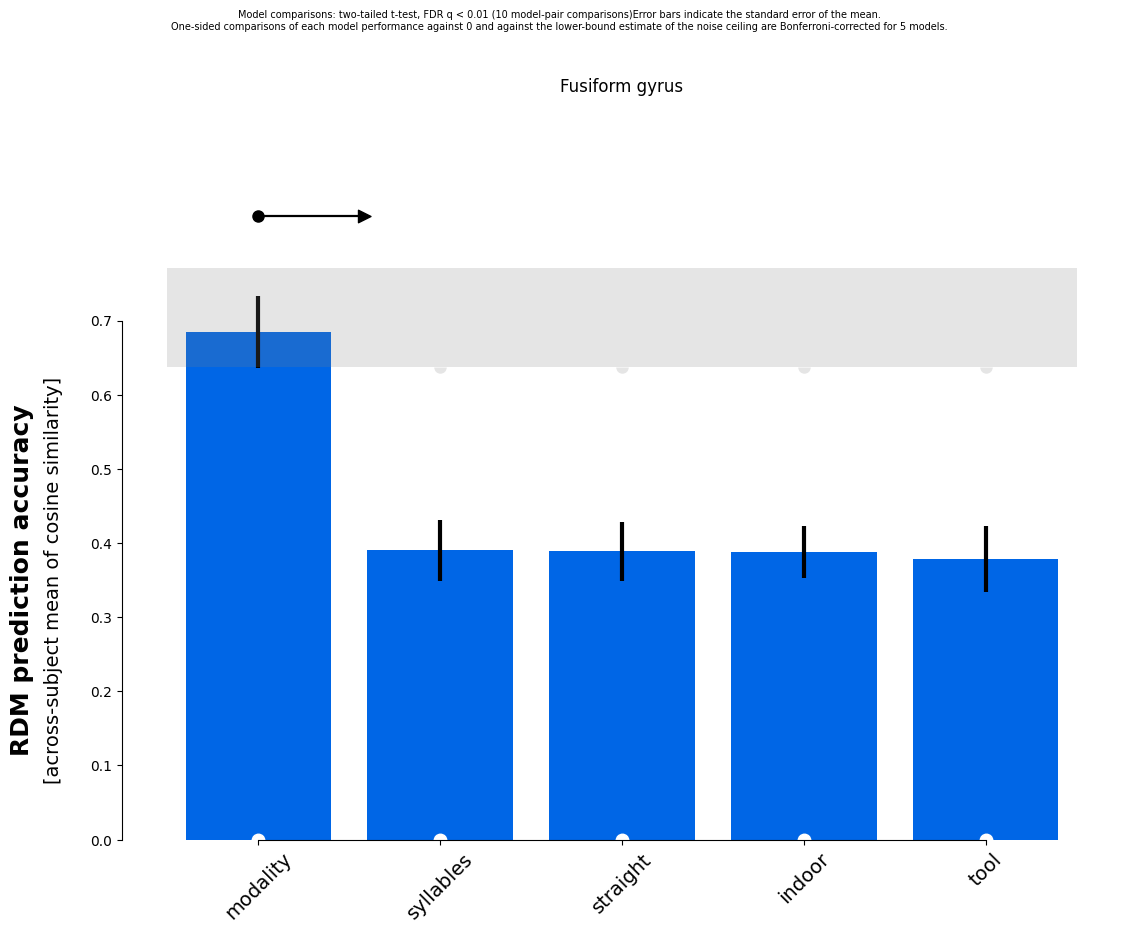

In [16]:
fig, _, _ = plot_model_comparison(result_fusiform, sort=True)
plt.title('Fusiform gyrus')
plt.show()

Notice that the modality, i.e. whether the stimulus was a word or an image, is easily the strongest model. Next is the number of syllables, and take into account that the Visual Word Form Area (VWFA) is on the fusiform gyrus.

In [17]:
result_it = eval_dual_bootstrap(models, data_rdms.subset('roi', 'inferiortemporal'))
print(result_it)

100%|██████████| 1000/1000 [00:05<00:00, 194.95it/s]

Results for running dual_bootstrap evaluation for cosine on 5 models:

Model     |   Eval ± SEM   | p (against 0) | p (against NC) |
-------------------------------------------------------------
indoor    |  0.202 ± 0.046 |        0.002  |         0.684  |
straight  |  0.204 ± 0.044 |        0.002  |         0.672  |
syllables |  0.211 ± 0.046 |        0.002  |         0.593  |
tool      |  0.226 ± 0.044 |        0.001  |         0.459  |
modality  |  0.273 ± 0.064 |        0.003  |         0.140  |

p-values are based on uncorrected t-tests


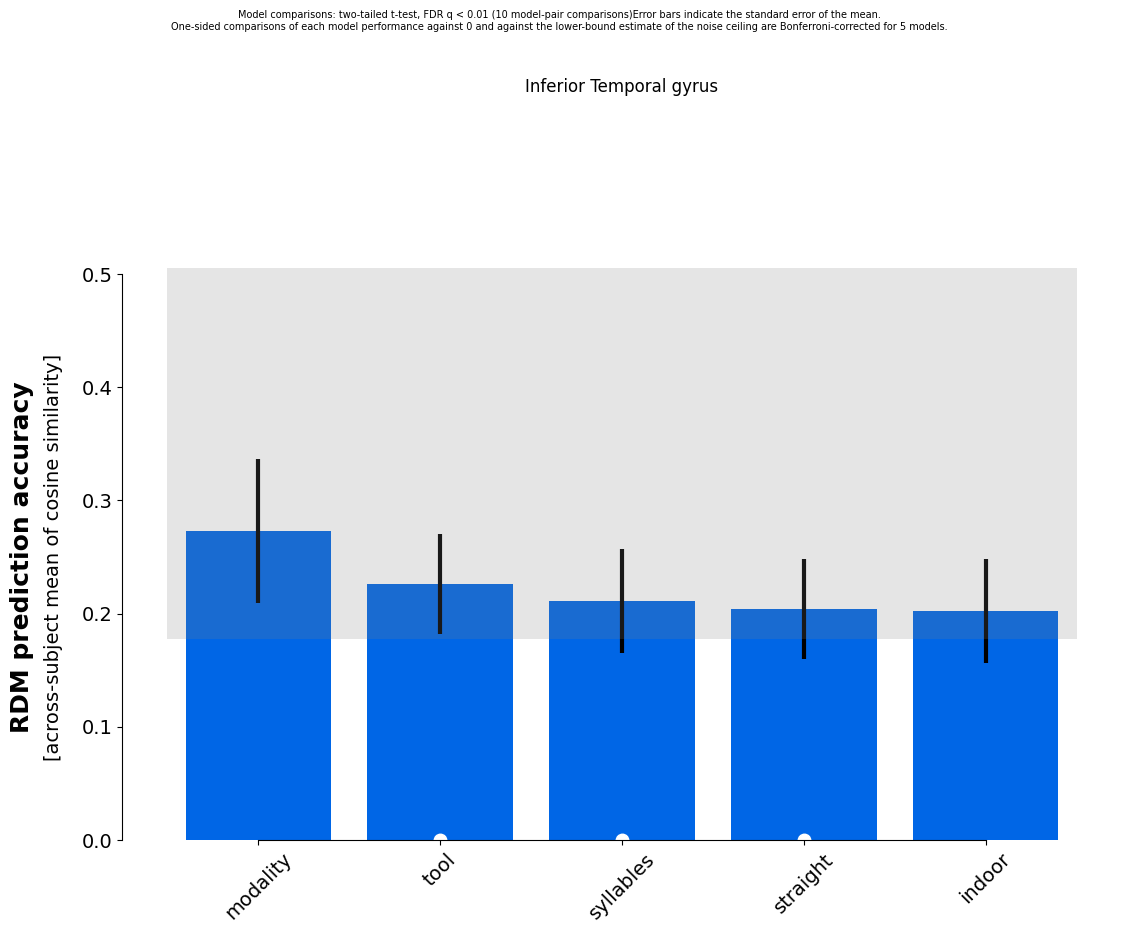

In [18]:
fig, _, _ = plot_model_comparison(result_it, sort=True)
plt.title('Inferior Temporal gyrus')
plt.show()

IT is known to be sensitive to object categories which may be why we see the "tool" contrast show up as second best model. Modality explains less here, potentially because the object representations in IT are also activated when we read the corresponding word.